# Example of Sequencing Radiance / Spectral Data
This notebook shows how spectral data (compiled by avgRadianceComplier.py) can be given to [the Sequencer](https://github.com/dalya/Sequencer) so that patterns in the data may be found. While this notebook should allow for a streamlined run of the Sequencer, you must first [install the Sequencer](https://github.com/dalya/Sequencer/blob/master/README.md). It is also recommened to have some [background on the Sequencer](http://sequencer.org/documentation). This notebook is intented to be interacted with (after reading through the sample run), so at a number of points there are variables for the user to modify.

In particular, the notebook will cover:
1. **Preperation:** Loading our data into numpy arrays, and taking a random sample.
1. **Running the Sequencer:** Defining relevent variables, running the Sequencer, and evalulating the "strength" of the identified pattern.
1. **Graphing Inputs and Outputs:** Creating 2D & 3D graphs to visualy compare inputs and outputs, and segmenting (zooming in) on parts of the graphs.

## Environment Setup
Before we start, required packages must be installed.
Also ensure that you have [installed the Sequencer](https://github.com/dalya/Sequencer/blob/master/README.md).

In [1]:
# Load in relevent Libararies
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.stats import wasserstein_distance
import umap
import sequencer
import random
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

## 1. Preperation
1.1) First, load in relevant data: the two CSV files that were output by avgRadianceComplier.py. ```path1``` must be the path to the CSV containing radiance, and ```path2``` must be the path to the CSV containting the wavelengths of light that data was collected for. Note: both paths must be modified by the user when running on their own local data.

1.2) Second, a random sample of the data will be taken; both the number of samples (```samples```) and the seed for the random sample (```random_seed```) can be modified by the user. The radiance CSV loaded through path1 has ~27,000 rows; so (to drastically improve run time) it can be helpful to take only a sample of the data. 

However, if you dont want to take a random sample, replace cell #1.2 with the following code: 
```
arrAvgRadianceSample = arrAvgRadiance
samples = len(arrAvgRadianceSample)
```

In [2]:
# 1.1)
# Variables for the user to modify:
path1 = "/home/matthew/chemCamRepository/programOutputs/avgRadianceToSol3644.csv"
path2 = "/home/matthew/chemCamRepository/programOutputs/wavelengths.csv"
samples = 1000
random_seed = 42

In [3]:
# 1.1 cont.)
# Load in .csv files
arrAvgRadiance = np.loadtxt(path1, delimiter=",", dtype=float)
arrWavelengths = np.loadtxt(path2, delimiter=",", dtype=float)

In [4]:
# 1.2)
# Take random sample of data
np.random.seed(random_seed)
np.random.shuffle(arrAvgRadiance)
arrAvgRadianceSample = arrAvgRadiance[:samples, :]

## 2. Running the Sequencer
#### Other Sequencer Inputs
2.1) First, define relevent variables that impact the Sequencer's run: ```estimator_list```, ```scale_list```, and ```output_path```. 
* **Estimator_list:** The Sequencer has four estimators: Euclidean Distance (L2), Kullback-Leibler Divergence (KL), Monge-Wasserstein / Earth Mover Distance (EMD), and Energy Distance (energy). Each of these is a different metric for "looking" at the data. In this example only EMD is used for simplicity and run time.
* **Scale_list:** 
    * Each list within the scale_list refers to an estimator. Each element within this 2D array is a scale. A scale of n splits the dataset into n parts along (in this case) the ```arrWavelengths``` axis.
    * In this case EMD will only be run with a scale of 1 (to substatially save runtime). However, I have found that large elongations in this dataset can be found with: ```estimator_list = ['EMD', 'energy']``` and ```scale_list = [[1, 2, 128, 256], [1, 2]]```.
    * For more context on scales and the important of a multi-scale approach, visit [this notebook](https://github.com/dalya/Sequencer/blob/master/examples/importance_of_multi_scale_approach.ipynb).
* **output_path:** This is the directory to which the Sequencer will output relevent information and files. One of which, ```distance_matrices.pkl```, allows for the user to re-load in their data instead of re-computing. While this notebook does not cover this topic, please refrence part 4 of [this notebook](https://github.com/dalya/Sequencer/blob/53a8920f1a19f4399338613c2b7b747dac545502/examples/basic_sequencer_functionalities.ipynb) if interested. 

#### Sequencer Outputs
2.2) Next, run the Sequencer and then examine the ```final_elongations``` list. Simply put, the larger the "elongation" value the better - anything over ~35 indicates the presence of a sequence (pattern) in the dataset.
* **Final_elongations:** A list of "elongations" (how much of a pattern is found) in the data at each metric and scale. 

2.3) Lastly, create a new array containing the ordered / sequenced version of the dataset using ```final_sequence```. We will then compare this ordered dataset to the original to see if the Sequencer really did identify any patterns. 
* **Final_sequence:** A list of the original data set's indicies now in the sequenced order.

In [5]:
# 2.1)
# Variables for the user to modify: 
estimator_list = ['EMD']
scale_list=[[1]]
output_path = "/home/matthew/chemCamRepository/outputDirectoryRadEx"

In [6]:
# 2.2)
# Runs The Sequencer (Note: this could take a while)
seq=sequencer.Sequencer(arrWavelengths, arrAvgRadianceSample, estimator_list, scale_list=scale_list)
final_elongation, final_sequence = seq.execute(output_path, to_use_parallelization=True) 

# Print elongations for each estimator and scale (the bigger the better)
print("\n\nresulting elongation for the Sequencer: ", final_elongation)
estimator_list, scale_list, elongation_list = seq.return_elongation_of_weighted_products_all_metrics_and_scales()
print("intermediate elongations for the different metrics and scales:")
for i in range(len(estimator_list)):
    print("metric=%s, scale=%s, elongation: %s" % (estimator_list[i], scale_list[i], np.round(elongation_list[i], 2)))

Parallelization is ON. Number of cores: 8
calculating the distance matrices for estimator: EMD, scale: 1
finished calculating this distance matrix list, it took: 111.7499349117279 seconds
dumped the distance matrix dictionaries to the file: /home/matthew/chemCamRepository/outputDirectoryRadEx/distance_matrices.pkl
strating to sequence the different scales and estimators
in estimator: EMD, scale: 1
dumped the elongations to the file: /home/matthew/chemCamRepository/outputDirectoryRadEx/elongations.pkl
dumped the full weighted distance matrix to the file: /home/matthew/chemCamRepository/outputDirectoryRadEx/weighted_distance_matrix.pkl


/home/matthew/.local/lib/python3.10/site-packages/sequencer/sequencer_.py:1025: RuntimeWarning: divide by zero encountered in true_divide
  distance_matrix = 1.0 / proximity_matrix_copy


dumped the sparse distance matrix to the file: <_io.BufferedWriter name='/home/matthew/chemCamRepository/outputDirectoryRadEx/sparse_distance_matrix.pkl'>
dumped the final sequences and elongation to the file: <_io.BufferedWriter name='/home/matthew/chemCamRepository/outputDirectoryRadEx/final_products.pkl'>


resulting elongation for the Sequencer:  44.785174
intermediate elongations for the different metrics and scales:
metric=EMD, scale=1, elongation: 44.79


In [7]:
# 2.3)
# Create new array - the ordered (sequenced) version of the data
arrAvgRadianceSampleOrdered = arrAvgRadianceSample[final_sequence, :]

## 3. Graphing Inputs and Outputs
3.1) First, the user may want to cut their ordered and original data set into segments to (a) only view parts of the data set and (b) save graphing runtime. This segmenting will be acomplished by excluding indicies from the arrWavelengths numpy array. Segmeting is effectivly zooming in on the wavelengths-axis of the resulting graphs.  

The following variables are intended to be modified by the user: 
* **Save:** Do you want to save a local copy of the graphs? True / False
* **Name:** This will be the name of the file if you choose to save the graph. Include .png or other format at the end of the name.
* **Resolution:** This is how detailed the saved image will be. 300 = 5k x 2.5k pixles. 
* **Cut1:** Used to cut data from the end of the dataset.
    * First int represents the starting index of the cut
    * Second int represents the ending index of the cut (typically the len(arrWavelengths) + 1)
* **Cut2:** Used to cut data from the front of the dataset. A list of two integers, the first representing the index
    * First int represents the starting index of the cut (typically 0)
    * Second int represents the ending index of the cut
* **Scale:** This is how "granular" the graph is where higher values = more detail.

Notes on Cutting / Segmenting:
* In this example ```cut1``` and ```cut2``` are used to only graph a segment of 1100 wavelengths from arrWavelengths (268nm - 320nm).
* When 0 is inputed to both ints of either ```cut1``` and ```cut2``` the corespoding cut will do nothing.
* Cuts specified in cell #3.1) will be applied there; so, to create differnt segments / cuts, modify and re-run that cell. 

3.2) Create a 2D or "birds eye view" graph of the data. 
See annotations below image to help with interpretaion. 

3.3) Create a 3D or side view graph of the data. 
See annotations below image to help with interpretaion. 

3.4) Unlike the 2D and 3D graphs of parts 3.2 and 3.3, the graphs created in this part allow for percision comparison between a few different wavelengths of light. These graphs have the same **Save**, **Name**, and **Resolution** variables as parts 3.2 and 3.3, however they have a few addition variables intended for the user to modify:
* **ListLabels:** A list of the Oxide / Element names for each of the four scatter plot graphs that will be produced. 
* **ListColors:** A list of the four colors of the graphs, each coresponding by index to their respective Oxide. 
* **ListWavelengthIndex:** A 2D array where each list is the wavelength index for one of the Oxides / Elements the user wants to graph. Because there can be a small handfull (2-5) of exact wavelength values for most Oxides, here the user can give the index range of the exact wavelengths (of the 6144 wavelength channels) they wish to include.
    * Ex: 2936, 2939. This would be 422.68, 422.72, and 422.76 nm. All of which are wavelengths of light associate with Ca.

In [8]:
# 3.1)
# Variables for the user to modify 
##############################################################################
save = False # Do you want to save the graph produced?
name2D = 'name2D.png' # Name of the graph
name3D = 'name3D.png'
resolution = 300 # Resolution of graphs (300, 600, or 1200) are standard
cut1 = [1600, 6145] # Exclude the data in this index range - has to be the end
cut2 = [0, 500] # Exclude the data in this index range - has to be the begining
scale = 25 # Masure of how granular graph is
##############################################################################

# Following code excludes segments of the data
arrSampleSubsect = arrAvgRadianceSample
arrOrderedSubsect = arrAvgRadianceSampleOrdered
arrWavelengthsSubsect = arrWavelengths

if cut1[0] == 0 and cut1[1] ==  0:
    pass
else: 
    arrSampleSubsect = np.delete(arrSampleSubsect, slice(cut1[0],cut1[1]), 1)
    arrOrderedSubsect = np.delete(arrOrderedSubsect, slice(cut1[0],cut1[1]), 1)
    arrWavelengthsSubsect = np.delete(arrWavelengthsSubsect, slice(cut1[0],cut1[1]), 0)

if cut2[0] == 0 and cut2[1] ==  0:
    pass
else: 
    arrSampleSubsect = np.delete(arrSampleSubsect, slice(cut2[0],cut2[1]), 1)
    arrOrderedSubsect = np.delete(arrOrderedSubsect, slice(cut2[0],cut2[1]), 1)
    arrWavelengthsSubsect = np.delete(arrWavelengthsSubsect, slice(cut2[0],cut2[1]), 0)

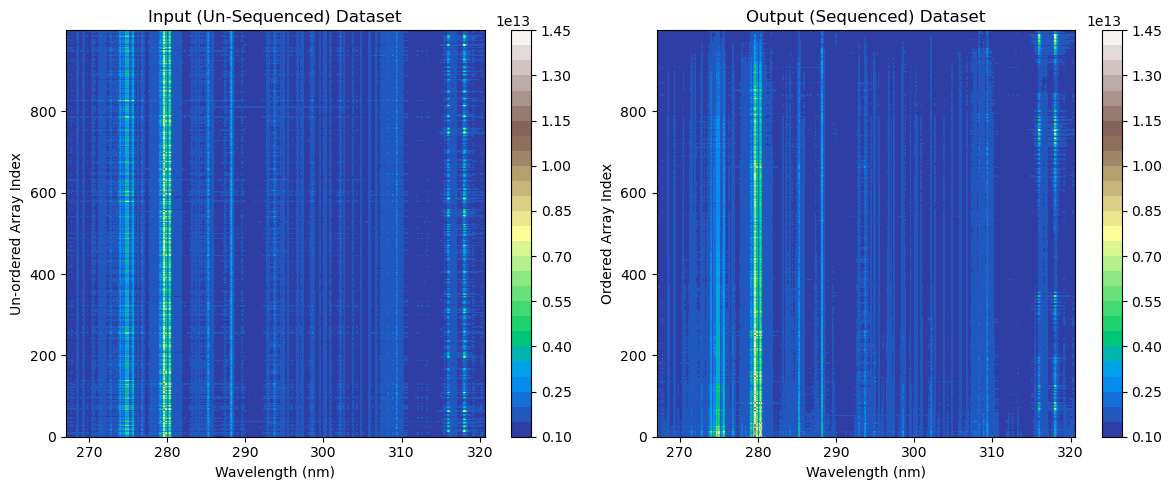

In [9]:
# 3.2)
# Following code creates a 2D comparison graph
arrayIndex = np.linspace(0, samples-1, num=samples, dtype=int)

# Left Graph
######################################################
plt.figure(1, figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Input (Un-Sequenced) Dataset")
plt.contourf(arrWavelengthsSubsect, arrayIndex, arrSampleSubsect, scale, cmap='terrain')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Un-ordered Array Index")
plt.colorbar()

# Right Graph
######################################################
plt.subplot(1, 2, 2)
plt.title("Output (Sequenced) Dataset")
plt.contourf(arrWavelengthsSubsect, arrayIndex, arrOrderedSubsect, scale, cmap='terrain')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Ordered Array Index")
plt.colorbar()

plt.tight_layout()
if save == True:
    plt.savefig(name2D, bbox_inches='tight', dpi=resolution)

### 3.2) Interpretaion of 2D Graph
#### The Sequencer in Context
* The Sequencer essenally rearranges rows so that similar data is next to each other, this can help identify patterns. 
* Each row in these graphs is a mean radiance column from a cl5\*CCS\*.csv file, meaning that each row is essentially one spectral reading of a rock surface / soil sample.
* We are essentially looking down on all of "mean" radiance columns (now rows) from a bird's eye view. 
* By understanding which wavelenth(s) display high/low radiance readings it can be determined which elements are present (assuming you know which wavelengths of light indicate the presense of which elements).

#### Understanding the Graphs
While this image is 2D it represents information in three dimentions:
* X: Wavelength of light (nm)
* Y: Un-Ordered & Ordered Array Index
* Color: Radiance values (times a large scale factor)

In comparing these images a few notable features can be discerned:
1. Radiances values at wavelengths of ~275nm and ~280nm where both sequenced so that higher values are closer to the x-axis.
2. There are still high values of radiance at ~280nm when there are relativly low values of radiance at ~275nm. 
3. At ~316nm groupings of relativly higher radiance of values (independent of the more pronouned sequecing of ~275nm and ~280nm) can be noticed. 

#### We can conclude:
* These rocks probably contain Fe, Mg, and Ca because light at ~275nm, ~280nm, and ~316nm correlats to these elements respectivly.
* Rock & soil samples with higher Fe tend to have higher Mg. However, rock & soil samples with high Mg can still have low Fe.
* In these rock & soil samples the presence of Ca and the presence of Fe & Mg are (somewhat) mutually exclusive.

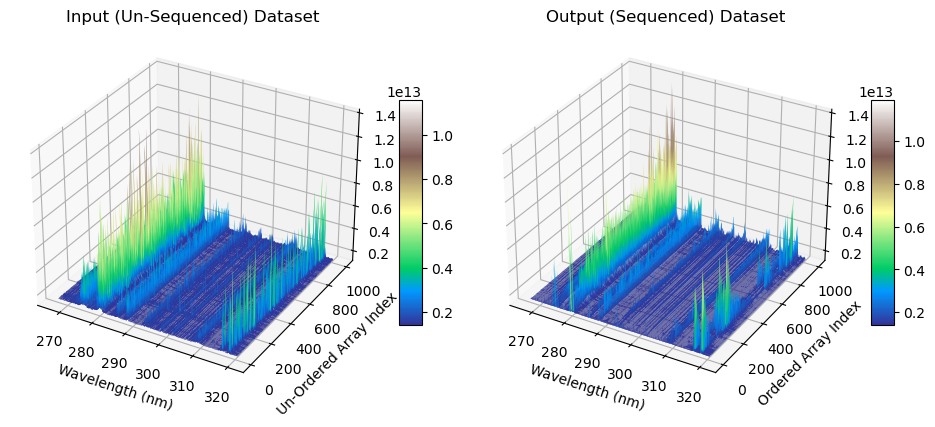

In [10]:
# 3.3)
# Following code creates a 3D comparison graph
y = np.linspace(0, samples-1, num=samples, dtype=int)
x = arrWavelengthsSubsect
X, Y = np.meshgrid(x, y)
fig = plt.figure(figsize=plt.figaspect(0.5))

# Left Graph
######################################################
Z = np.flip(arrSampleSubsect, 0) # Flips rows to better view image
ax = fig.add_subplot(121, projection='3d')
p = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                 cmap='terrain', linewidth=0, antialiased=True)
ax.set_title('Input (Un-Sequenced) Dataset');
plt.xlabel("Wavelength (nm)")
plt.ylabel("Un-Ordered Array Index")
fig.colorbar(p, shrink=0.5, aspect=10, ax=ax)

# Right Graph
######################################################
Z = np.flip(arrOrderedSubsect, 0) # Flips rows to better view image
ax = fig.add_subplot(122, projection='3d')
p = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                 cmap='terrain', linewidth=0, antialiased=True)
ax.set_title('Output (Sequenced) Dataset');
plt.xlabel("Wavelength (nm)")
plt.ylabel("Ordered Array Index")
fig.colorbar(p, shrink=0.5, aspect=10, ax=ax)

plt.tight_layout()
if save == True:
    plt.savefig(name3D, bbox_inches='tight', dpi=resolution)

### 3.2) Interpretaion of 3D Graph
#### The Sequencer in Context
* The Sequencer essenally rearranges rows so that similar data is next to each other, this can help identify patterns. 
* Each row in these graphs is a mean radiance column from a cl5\*CCS\*.csv file, meaning that each row is essentially one spectral reading of a rock surface / soil sample.
* We are essentially looking down on all of mean radiance columns (now rows) from a bird's eye view. 
* By understanding which wavelenth(s) display high/low radiance readings it can be determined which elements are present (assuming you know which wavelengths of light indicate the presense of which elements).

#### Understanding the Graphs
These images are 3D but could present information in another dimention (their color); however, both color and vertical elevation represent the same information:
* X: Wavelength of light (nm)
* Y: Un-Ordered & Ordered Array Index
* Z: Radiance values (times a large scale factor)
* Color: Radiance values (times a large scale factor)

In comparing these images a few notable features can be discerned:
1. Radiances values at wavelengths of ~275nm and ~280nm where both sequenced so that higher values are closer to the x-axis.
2. There are still high values of radiance at ~280nm when there are relativly low values of radiance at ~275nm. 
3. At ~316nm groupings of relativly higher radiance of values (independent of the more pronouned sequecing of ~275nm and ~280nm) can be noticed. 

#### We can conclude:
* These rocks probably contain Fe, Mg, and Ca because light at ~275nm, ~280nm, and ~316nm correlats to these elements respectivly.
* Rock & soil samples with higher Fe tend to have higher Mg. However, rock & soil samples with high Mg can still have low Fe.
* The concentration of Ca in these rocks is (somewhat) indepent of the concentration of Fe and Mg.

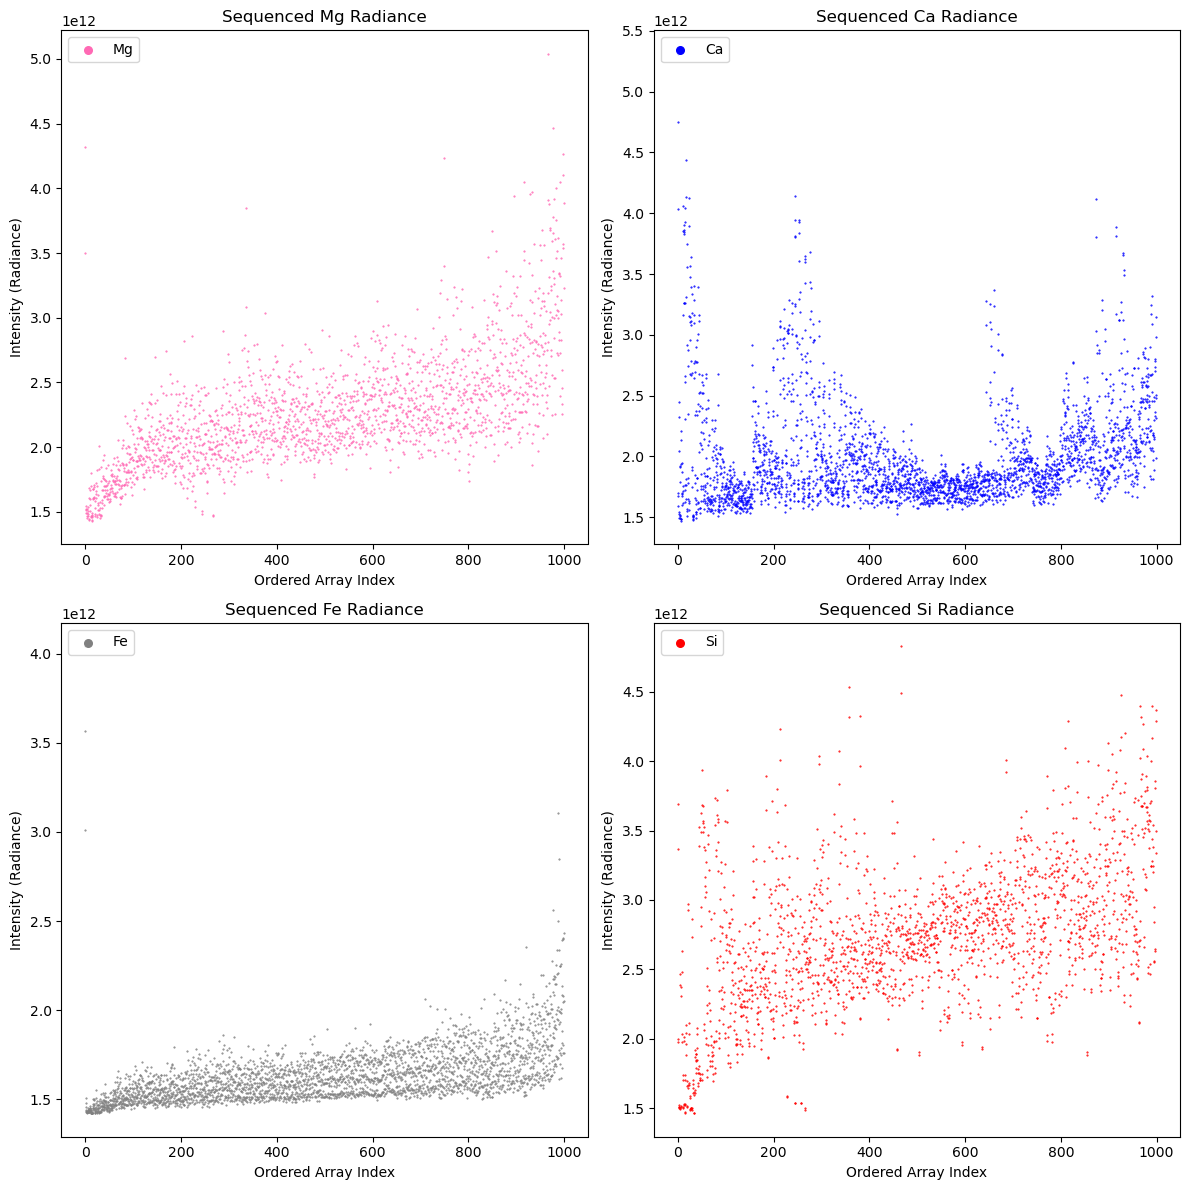

In [12]:
# 3.4)
# Variables for the user to modify 
#########################################################
listLabels = ['Mg', 'Ca', 'Fe', 'Si']
listColors = ['HotPink', 'Blue', 'Grey', 'Red']
listWavelengthIndex = [
    [860, 862], # Mg @ 285.18, & 285.23 nm
    [2936, 2939], # Ca @ 422.68, 422.72, & 422.76 nm
    [2527, 2530], # Fe @ 404.50, 404.54, & 404.59 nm
    [920, 922]] # Si @ 288.15, & 288.20 nm
save = False
name = "name.png"
resolution = 300
###########################################################

plt.figure(1, figsize=(12, 12))
y = np.flip(arrAvgRadianceSampleOrdered.transpose(), 1)
x = np.arange(0, samples)
for i in range(len(listLabels)):
    for j in range(listWavelengthIndex[i][0], listWavelengthIndex[i][1]):
        plt.subplot(2, 2, i+1)
        plt.scatter(x, y[j], s=0.25, color = listColors[i])
    lgnd = plt.legend([listLabels[i]], loc="upper left")
    lgnd.legendHandles[0]._sizes = [30]
    plt.title("Sequenced " + listLabels[i] + " Radiance");
    plt.xlabel("Ordered Array Index")
    plt.ylabel("Intensity (Radiance)")

plt.tight_layout()
if save == True:
    plt.savefig(name, bbox_inches='tight', dpi=resolution)